In [22]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
import warnings
warnings.filterwarnings('ignore')



In [5]:
df_challenger = pd.read_csv(r'Script e Project\challenger.csv', delimiter=',')
df_challenger.head()


,desgaste,temperatura,pressão,t
0,0,66,50,1
1,1,70,50,2
2,0,69,50,3
3,0,68,50,4
4,0,67,50,5


In [6]:
# características das variáveis do dataset
df_challenger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   desgaste     23 non-null     int64
 1   temperatura  23 non-null     int64
 2   pressão      23 non-null     int64
 3   t            23 non-null     int64
dtypes: int64(4)
memory usage: 868.0 bytes


In [7]:
df_challenger.describe()

,desgaste,temperatura,pressão,t
count,23.000000,23.000000,23.000000,23.00000
mean,0.304348,69.565217,152.173913,12.00000
std,0.558796,7.057080,68.221332,6.78233
min,0.000000,53.000000,50.000000,1.00000
25%,0.000000,67.000000,75.000000,6.50000
50%,0.000000,70.000000,200.000000,12.00000
75%,0.500000,75.000000,200.000000,17.50000
max,2.000000,81.000000,200.000000,23.00000


- desgaste: quantidade de vezes em que ocorreu stress térmico
- temperatura: temperatura de lançamento (graus fahrenheit)
- pressão: pressão de verificação de vazamento (psi: libra-força por polegada ao quadrado)
- t: teste para lançamento (id)

In [11]:
# criar função para converter ºF para ºC
def celsius(far):
    celsius = 5*((far-32)/9)
    print(celsius)


In [15]:
# criar uma variável binária considerando a ocorrência de desgastes de peças
df_challenger.loc[df_challenger['desgaste'] != 0,'falha'] = 1
df_challenger.loc[df_challenger['desgaste'] == 0,'falha'] = 0

df_challenger['falha'] = df_challenger['falha'].astype(int)


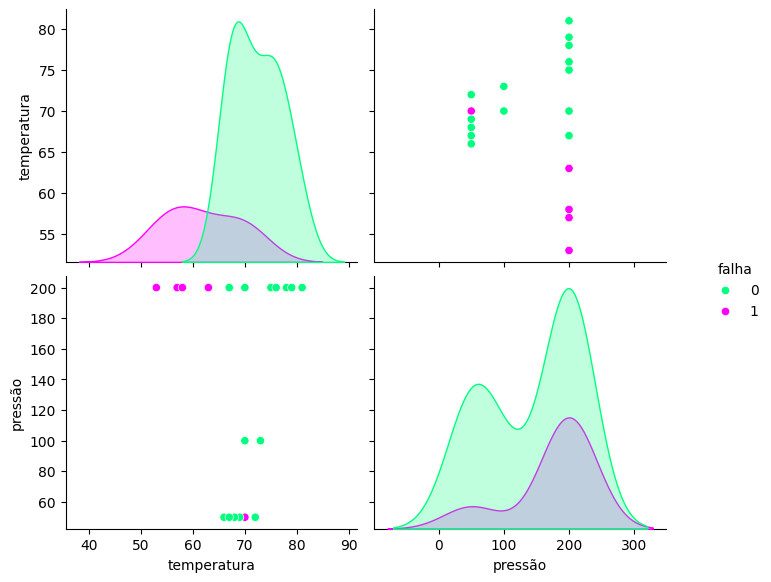

In [19]:
# criar gráficos 'pairplot' com scatters e KDEs por 'falha'

cores_desejadas = {0:'springgreen', 1:'magenta'}

g = sns.pairplot(df_challenger[['falha','temperatura','pressão']],
                 hue='falha',
                 palette=cores_desejadas)

g.figure.set_size_inches(8,6)
plt.show()

- os ensaios com temperaturas maiores não ocorreram falhas
- os ensaios com temperaturas menores ocorreram falhas


In [21]:
# estimação do modelo logístico binário

modelo_challenger = sm.Logit.from_formula('falha ~ temperatura + pressão',
                                          df_challenger).fit()



print(modelo_challenger.summary())


Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            2
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.4685
Time:                        14:38:22   Log-Likelihood:                -7.0164
converged:                       True   LL-Null:                       -13.201
Covariance Type:            nonrobust   LLR p-value:                  0.002061
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      21.8436     11.936      1.830      0.067      -1.551      45.239
temperatura    -0.3501    

- beta da variável pressão não tem significância estatística, de acordo com o teste z

In [23]:
# Carregamento da função 'stepwise' do pacote 'statstests.process'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/
from statstests.process import stepwise

# estimação do modelo por meio do procedimento stepwise
step_challenger = stepwise(modelo_challenger, pvalue_limit=0.05)




Regression type: Logit 

Estimating model...: 
 falha ~ Q('temperatura') + Q('pressão')
Optimization terminated successfully.
         Current function value: 0.305063
         Iterations 8

 Discarding atribute "Q('pressão')" with p-value equal to 0.5378022290437205 

Estimating model...: 
 falha ~ Q('temperatura')
Optimization terminated successfully.
         Current function value: 0.313604
         Iterations 8

 No more atributes with p-value higher than 0.05

 Atributes discarded on the process...: 

{'atribute': "Q('pressão')", 'p-value': np.float64(0.5378022290437205)}

 Model after stepwise process...: 
 falha ~ Q('temperatura') 

                           Logit Regression Results                           
Dep. Variable:                  falha   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Sep 20

A equação do modelo logístico binário é:

$$
\text{logit}(p) = 23.7750 - 0.3667 \times \text{temperatura}
$$

A função logística para a probabilidade \(p\) é:

$$
p = \frac{1}{1 + e^{-(23.7750 - 0.3667 \times \text{temperatura})}}
$$

- quanto maior a temperatura, menor a probabilidade de falha
- quanto menor a temperatura, maior a probabilidade de falha

In [25]:
# exemplo 1) qual a probabilidade média de falha a 70ºF?
step_challenger.predict(pd.DataFrame({'temperatura':[70]}))

# 0.130777 = 13,07%

0    0.130777
dtype: float64

In [27]:
# exemplo 1) qual a probabilidade média de falha a 70ºF?
step_challenger.predict(pd.DataFrame({'temperatura':[77]}))

# 0.011419 = 1,1419%

0    0.011419
dtype: float64

In [28]:
# exemplo 1) qual a probabilidade média de falha a 70ºF?
step_challenger.predict(pd.DataFrame({'temperatura':[34]}))

# 0.999988 = 99,99%

0    0.999988
dtype: float64

In [30]:
# atribuindo uma coluna no dataframe para os resultados
df_challenger['phat'] = step_challenger.predict()
df_challenger.head()

,desgaste,temperatura,pressão,t,falha,phat
0,0,66,50,1,0,0.394770
1,1,70,50,2,1,0.130777
2,0,69,50,3,0,0.178373
3,0,68,50,4,0,0.238539
4,0,67,50,5,0,0.311309


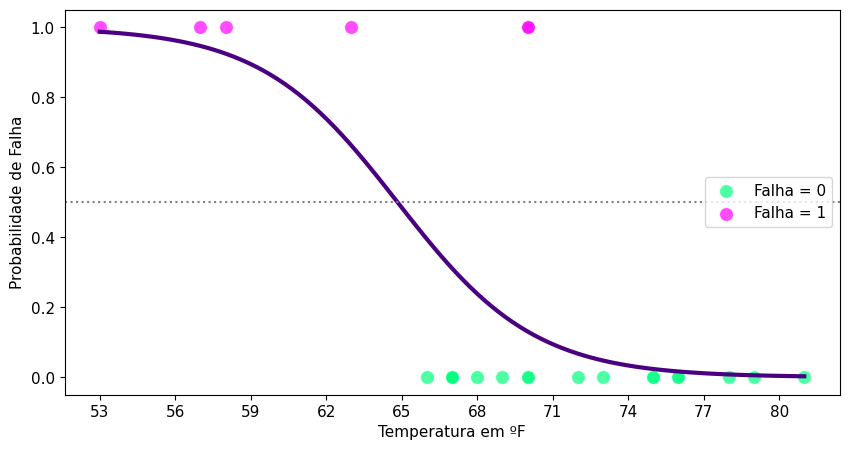

In [39]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 0],
                y=df_challenger['falha'][df_challenger['falha'] == 0],
                color='springgreen', alpha=0.7, s=100, label='Falha = 0')
sns.scatterplot(x=df_challenger['temperatura'][df_challenger['falha'] == 1],
                y=df_challenger['falha'][df_challenger['falha'] == 1],
                color='magenta', alpha=0.7, s=100, label='Falha = 1')
sns.regplot(x=df_challenger['temperatura'], y=df_challenger['falha'],
            logistic=True, ci=None, scatter=False,
            line_kws={'color': 'indigo', 'linewidth': 3})
plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
plt.xlabel('Temperatura em ºF', fontsize=11)
plt.ylabel('Probabilidade de Falha', fontsize=11)
plt.xticks(np.arange(df_challenger['temperatura'].min(),
                     df_challenger['temperatura'].max() + 0.01, 3),
           fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.legend(fontsize=11, loc='center right')
plt.show()


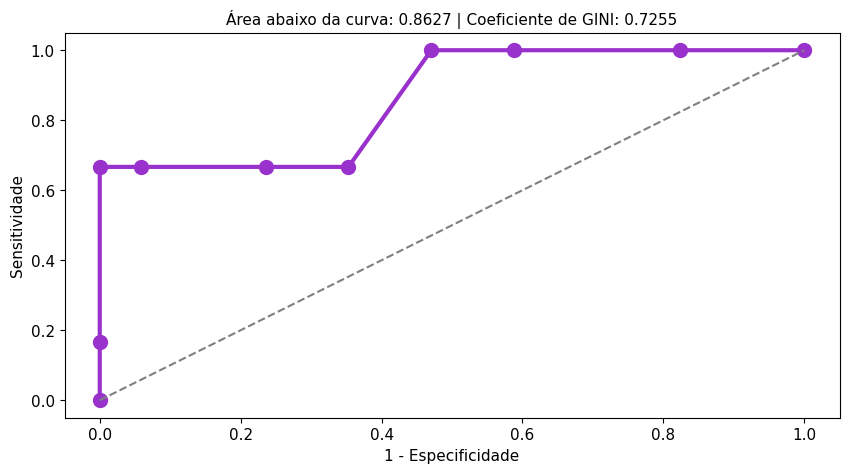

In [44]:
# Construção da curva ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds =roc_curve(df_challenger['falha'], df_challenger['phat'])
roc_auc = auc(fpr, tpr)

# Cálculo do coeficiente de GINI
gini = (roc_auc - 0.5)/(0.5)

# Plotando a curva ROC
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=11)
plt.xlabel('1 - Especificidade', fontsize=11)
plt.ylabel('Sensitividade', fontsize=11)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=11)
plt.show()


Curva ROC
- sensitividade (TPR) = TP/(TP+FN). TPR (taxa de verdadeiros positivos), é a proporção de positivos corretamente identificados
- especificidade (FPR) = FP/(FP+TN). FPR (taxa de falsos negativos), é a proporção de negativos incorretamente identificados
imagine um detector de fumaça:
    - verdadeiro positivo (TP): o detector apita quando há um incêndio
    - falso positivo (FP): o detector apita, mas não há um incêndio
    - verdadeiro negativo (TN): o detector não apita quando não há incêndio
    - falso negativo (FN): o detector não apita, mas há um incêndio 
- a curva ROC ajuda a entender a sensibilidade do detector em relação a falsos alarmes
- a busca pela maior área abaixo da curva ROC, indica um bom modelo
